In [4]:
pip install torch transformers pytorch-lightning datasets roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 726.8 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 32.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 32.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 kB 1.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━

In [12]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader
import numpy as np
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


torch.cuda.empty_cache()

# SegFormer 모델과 피처 추출기 로드
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b4-finetuned-ade-512-512", 
    num_labels=3,  
    ignore_mismatched_sizes=True
)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")

# 색상 맵 (건물을 흰색, 새롭게 추가된 노후도 요인을 빨간색으로 표시)
color_map = {
    0: [0, 0, 0],        # 배경 (검은색)
    1: [255, 255, 255],  # 건물 (흰색)
    2: [255, 0, 0],      # 균열, 부식 등 새로 추가한 객체 (빨간색)
}

# 이미지 전처리 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs, image

# 분할 결과 시각화 함수 (반투명 오버레이)
def visualize_segmentation_overlay(image, segmentation, color_map, alpha=0.5):
    height, width = segmentation.shape
    segmented_image = np.zeros((height, width, 3), dtype=np.uint8)

    # segmentation 값을 color_map에 따라 색상 할당
    for class_id, color in color_map.items():
        segmented_image[segmentation == class_id] = color

    segmented_image_pil = Image.fromarray(segmented_image)

    # 원본 이미지와 분할된 이미지를 혼합 (alpha 값으로 투명도 조절)
    blended_image = Image.blend(image.convert("RGB"), segmented_image_pil.convert("RGB"), alpha=alpha)

    return blended_image

# Custom Dataset Class
class CustomSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, masks_folder, feature_extractor):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.feature_extractor = feature_extractor
        self.image_files = sorted(os.listdir(images_folder))
        self.mask_files = sorted(os.listdir(masks_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        mask_path = os.path.join(self.masks_folder, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        inputs = self.feature_extractor(images=image, segmentation_maps=mask, return_tensors="pt")
        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'labels': inputs['labels'].squeeze()
        }

# 로컬 데이터셋 경로 설정
train_images_folder = "fine_tuning_data_v2/train/image"  # 훈련 이미지가 저장된 경로
train_masks_folder = "fine_tuning_data_v2/train/label"   # 훈련 마스크가 저장된 경로
val_images_folder = "fine_tuning_data_v2/valid/image"    # 검증 이미지가 저장된 경로
val_masks_folder = "fine_tuning_data_v2/valid/label"     # 검증 마스크가 저장된 경로

# 데이터셋 로드
train_dataset = CustomSegmentationDataset(images_folder=train_images_folder, masks_folder=train_masks_folder, feature_extractor=feature_extractor)
val_dataset = CustomSegmentationDataset(images_folder=val_images_folder, masks_folder=val_masks_folder, feature_extractor=feature_extractor)

# DataLoader 설정
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=12)

# Fine-tuning용 Lightning Module 정의
class SegformerFineTuner(pl.LightningModule):
    def __init__(self, model):
        super(SegformerFineTuner, self).__init__()
        self.model = model

    def forward(self, pixel_values, labels):
        outputs = self.model(pixel_values=pixel_values, labels=labels)
        return outputs.loss, outputs.logits

    def training_step(self, batch, batch_idx):
        pixel_values, labels = batch['pixel_values'], batch['labels']
        loss, logits = self(pixel_values, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        pixel_values, labels = batch['pixel_values'], batch['labels']
        loss, logits = self(pixel_values, labels)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=5e-5)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = torch.device("cuda:1")  # GPU 1번 선택
model = model.to(device)

# 체크포인트 콜백 설정
checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")

trainer = pl.Trainer(
    accelerator="ddp",  # DDP를 위한 분산 학습 설정
    gpus=1,  # 1개의 GPU 사용
    max_epochs=200,  # 학습할 epoch 수
    callbacks=[checkpoint_callback]
)


# Fine-tuning 수행
finetuner = SegformerFineTuner(model=model)
trainer.fit(finetuner, train_dataloader, val_dataloader)

# Fine-tuning된 모델 저장
finetuner.model.save_pretrained("finetuned_segformer")

# 저장된 모델 로드 및 추론
finetuned_model = SegformerForSemanticSegmentation.from_pretrained("finetuned_segformer")

# 추론 예시
inputs, image = preprocess_image("fine_tuning_data/data/test/image/5_png.rf.b7f2b598dfb918f1c1870e57941ed4eb.jpg")
with torch.no_grad():
    outputs = finetuned_model(pixel_values=inputs['pixel_values'])

logits = outputs.logits
upsampled_logits = torch.nn.functional.interpolate(logits, size=(image.size[1], image.size[0]), mode='bilinear', align_corners=False)
predicted_segmentation = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# 결과 시각화
blended_image = visualize_segmentation_overlay(image, predicted_segmentation, color_map)
blended_image.show()


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# V2

In [7]:
torch.cuda.empty_cache()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([152, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([152]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 64.1 M
-----------------------------------------------------------
64.1 M    Trainable params
0         Non-trainable params
64.1 M  

Epoch 0:   0%|          | 0/8 [00:00<?, ?it/s]                        

[rank0]:[W reducer.cpp:1360] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())


Epoch 0:  12%|█▎        | 1/8 [00:01<00:07,  1.03s/it, loss=5.24, v_num=3]

/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [152, 768, 1, 1], strides() = [768, 1, 768, 768]
bucket_view.sizes() = [152, 768, 1, 1], strides() = [768, 1, 1, 1] (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831440/work/torch/csrc/distributed/c10d/reducer.cpp:322.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0:  75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s, loss=5.08, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 1:  75%|███████▌  | 6/8 [00:03<00:01,  1.75it/s, loss=4.91, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 2:  75%|███████▌  | 6/8 [00:03<00:01,  1.71it/s, loss=4.76, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 3:  75%|███████▌  | 6/8 [00:03<00:01,  1.70it/s, loss=4.5, v_num=3] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  75%|███████▌  | 6/8 [00:03<00:01,  1.78it/s, loss=4.2, v_num=3] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  75%|███████▌  | 6/8 [00:03<00:01,  1.76it/s, loss=3.92, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 6:  75%|███████▌  | 6/8 [00:03<00:01,  1.76it/s, loss=3.66, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 7:  75%|███████▌  | 6/8 [00:03<00:01,  1.71it/s, loss=3.43, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 8:  75%|███████▌  | 6/8 [00:03<00:01,  1.74it/s, loss=3.24, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 9:  75%|███████▌  | 6/8 [00:03<00:01,  1

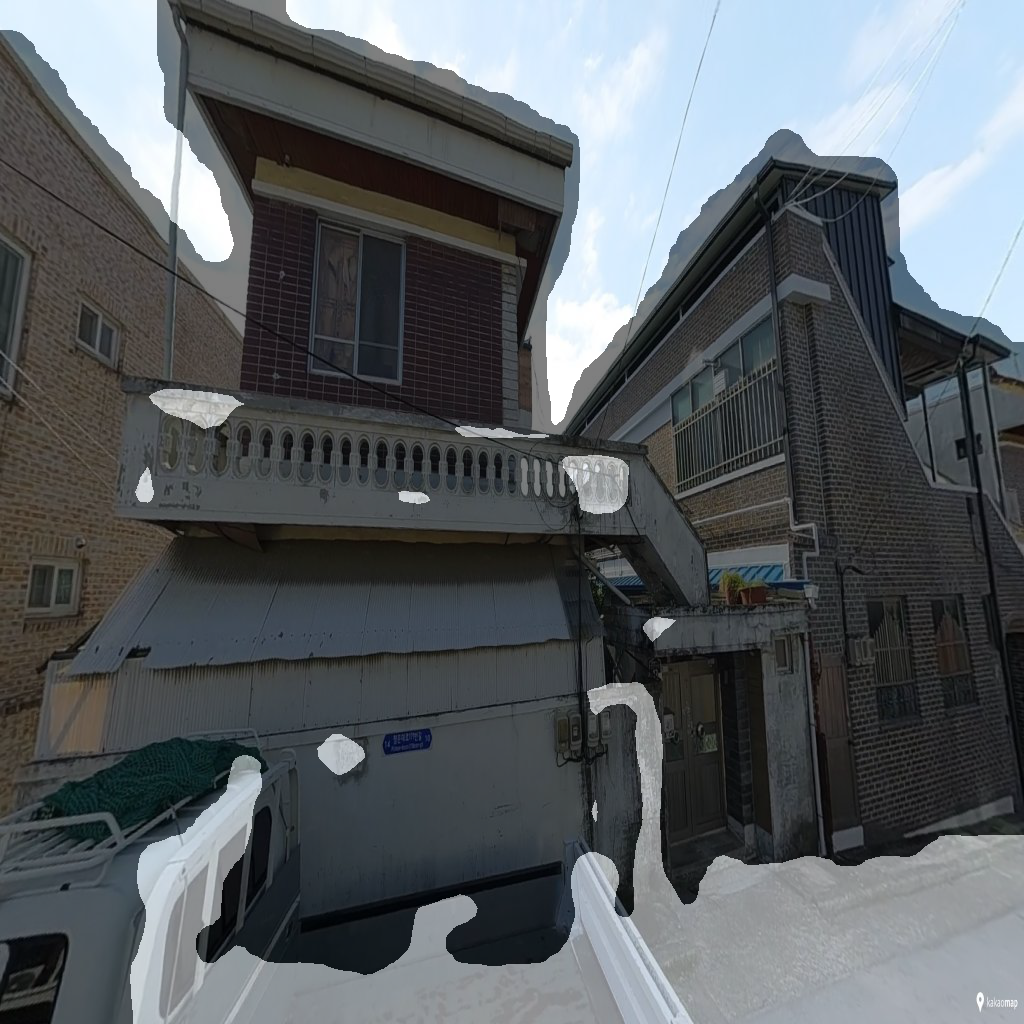

In [19]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader
import numpy as np
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

torch.cuda.empty_cache()

# GPU 설정: GPU 0번 사용
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0")  # GPU 0번 사용

# SegFormer 모델과 피처 추출기 로드
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b4-finetuned-ade-512-512", 
    num_labels=152,  
    ignore_mismatched_sizes=True
)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")

# 모델을 GPU 0번으로 이동
model = model.to(device)

# 색상 맵 (건물을 흰색, 새롭게 추가된 노후도 요인을 빨간색으로 표시)
color_map = {
    0: [0, 0, 0],        # 배경 (검은색)
    1: [255, 255, 255],  # 건물 (흰색)
    2: [255, 0, 0],      # 균열, 부식 등 새로 추가한 객체 (빨간색)
}

# 이미지 전처리 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs, image

# 분할 결과 시각화 함수 (반투명 오버레이)
def visualize_segmentation_overlay(image, segmentation, color_map, alpha=0.5):
    height, width = segmentation.shape
    segmented_image = np.zeros((height, width, 3), dtype=np.uint8)

    # segmentation 값을 color_map에 따라 색상 할당
    for class_id, color in color_map.items():
        segmented_image[segmentation == class_id] = color

    segmented_image_pil = Image.fromarray(segmented_image)

    # 원본 이미지와 분할된 이미지를 혼합 (alpha 값으로 투명도 조절)
    blended_image = Image.blend(image.convert("RGB"), segmented_image_pil.convert("RGB"), alpha=alpha)

    return blended_image

# Custom Dataset Class
class CustomSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, masks_folder, feature_extractor):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.feature_extractor = feature_extractor
        self.image_files = sorted(os.listdir(images_folder))
        self.mask_files = sorted(os.listdir(masks_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        mask_path = os.path.join(self.masks_folder, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        inputs = self.feature_extractor(images=image, segmentation_maps=mask, return_tensors="pt")
        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'labels': inputs['labels'].squeeze()
        }

# 로컬 데이터셋 경로 설정
train_images_folder = "fine_tuning_data_v2/train/image"  # 훈련 이미지가 저장된 경로
train_masks_folder = "fine_tuning_data_v2/train/label"   # 훈련 마스크가 저장된 경로
val_images_folder = "fine_tuning_data_v2/valid/image"    # 검증 이미지가 저장된 경로
val_masks_folder = "fine_tuning_data_v2/valid/label"     # 검증 마스크가 저장된 경로

# 데이터셋 로드
train_dataset = CustomSegmentationDataset(images_folder=train_images_folder, masks_folder=train_masks_folder, feature_extractor=feature_extractor)
val_dataset = CustomSegmentationDataset(images_folder=val_images_folder, masks_folder=val_masks_folder, feature_extractor=feature_extractor)

# DataLoader 설정
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)

# Fine-tuning용 Lightning Module 정의
class SegformerFineTuner(pl.LightningModule):
    def __init__(self, model):
        super(SegformerFineTuner, self).__init__()
        self.model = model

    def forward(self, pixel_values, labels):
        outputs = self.model(pixel_values=pixel_values, labels=labels)
        return outputs.loss, outputs.logits

    def training_step(self, batch, batch_idx):
        pixel_values, labels = batch['pixel_values'], batch['labels']
        loss, logits = self(pixel_values, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        pixel_values, labels = batch['pixel_values'], batch['labels']
        loss, logits = self(pixel_values, labels)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=5e-5)

# 체크포인트 콜백 설정
checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")

# GPU 0번만 사용하는 Trainer 설정
trainer = pl.Trainer(
    accelerator="ddp",  # GPU 사용
    gpus=1,  # GPU 1개 사용 (GPU 0번 사용)
    max_epochs=200,  # 학습할 epoch 수
    callbacks=[checkpoint_callback]
)

# Fine-tuning 수행
finetuner = SegformerFineTuner(model=model)
trainer.fit(finetuner, train_dataloader, val_dataloader)

# Fine-tuning된 모델 저장
finetuner.model.save_pretrained("finetuned_segformer")

# 저장된 모델 로드 및 추론
finetuned_model = SegformerForSemanticSegmentation.from_pretrained("finetuned_segformer")

# 추론 예시
inputs, image = preprocess_image("fine_tuning_data/data/test/image/5_png.rf.b7f2b598dfb918f1c1870e57941ed4eb.jpg")
with torch.no_grad():
    outputs = finetuned_model(pixel_values=inputs['pixel_values'])

logits = outputs.logits
upsampled_logits = torch.nn.functional.interpolate(logits, size=(image.size[1], image.size[0]), mode='bilinear', align_corners=False)
predicted_segmentation = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# 결과 시각화
blended_image = visualize_segmentation_overlay(image, predicted_segmentation, color_map)
blended_image.show()


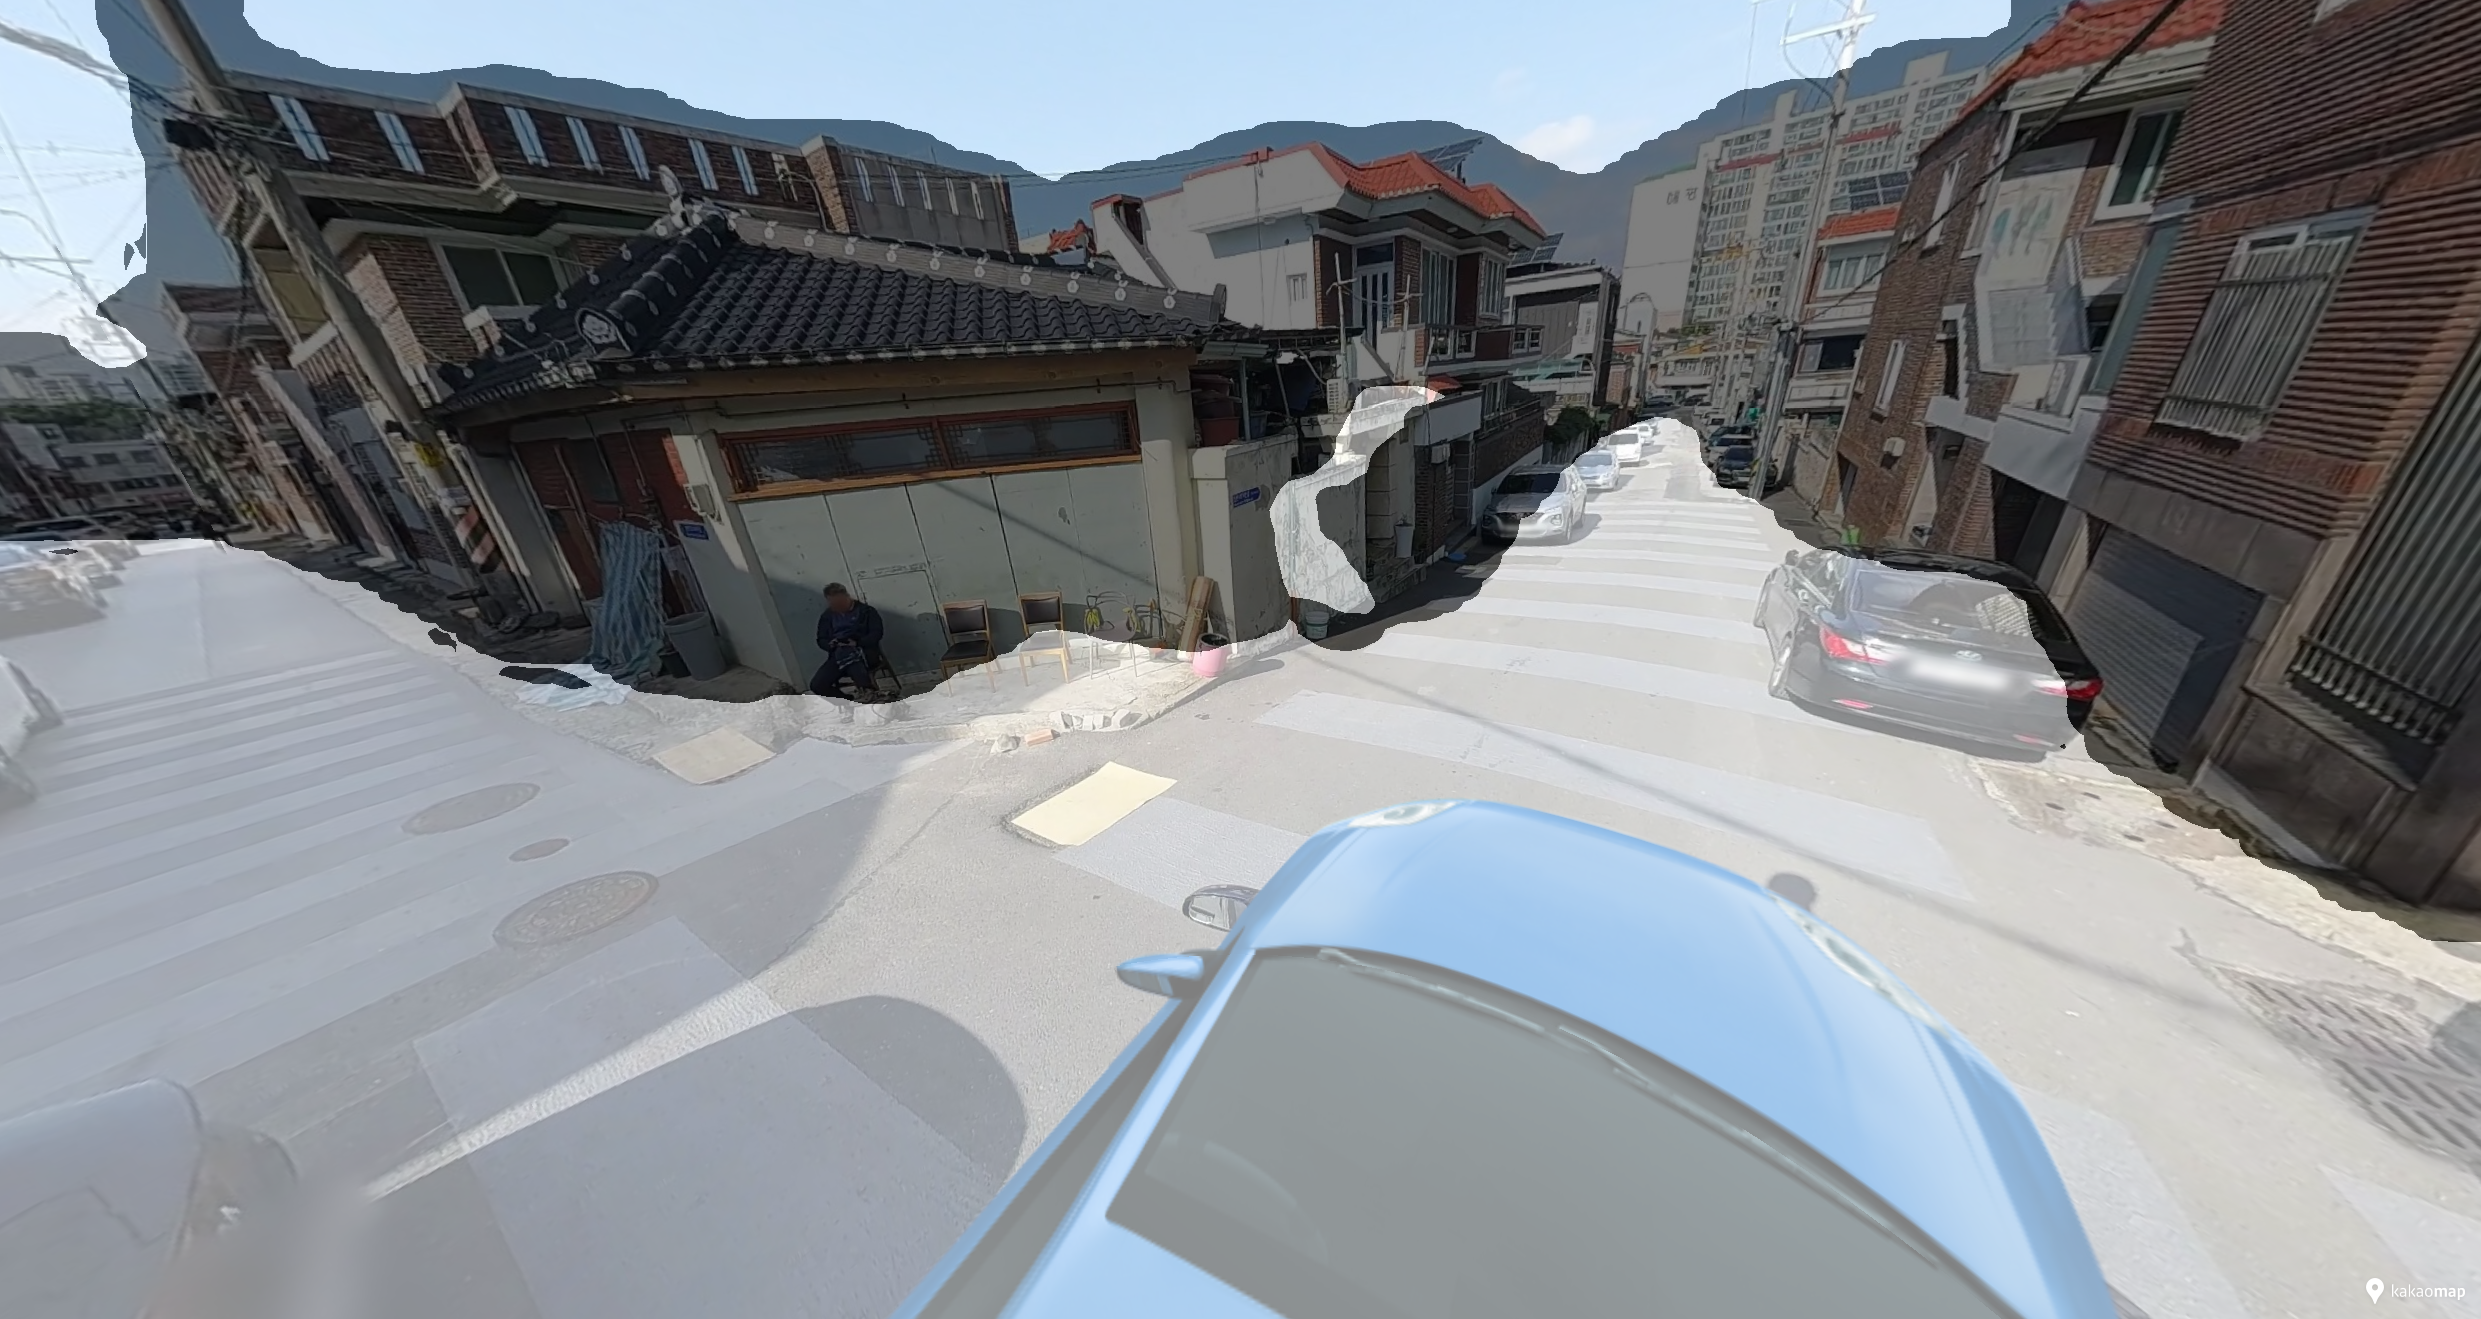

In [24]:
import os
from PIL import Image
import torch
import numpy as np
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# Fine-tuning된 SegFormer 모델 로드
finetuned_model = SegformerForSemanticSegmentation.from_pretrained("finetuned_segformer")

# Feature Extractor 로드 (Fine-tuning 시 사용된 동일한 Feature Extractor)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")

color_map = {
    0: [0, 0, 0],        # 배경 (검은색)
    1: [255, 255, 255],  # 건물 (흰색)
    2: [255, 0, 0],      # 균열 및 부식 (빨간색)
}


# 이미지 전처리 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs, image

# 분할 결과 시각화 함수 (반투명 오버레이)
def visualize_segmentation_overlay(image, segmentation, color_map, alpha=0.5):
    height, width = segmentation.shape
    segmented_image = np.zeros((height, width, 3), dtype=np.uint8)

    # segmentation 값을 color_map에 따라 색상 할당
    for class_id, color in color_map.items():
        segmented_image[segmentation == class_id] = color

    segmented_image_pil = Image.fromarray(segmented_image)

    # 원본 이미지와 분할된 이미지를 혼합 (alpha 값으로 투명도 조절)
    blended_image = Image.blend(image.convert("RGB"), segmented_image_pil.convert("RGB"), alpha=alpha)

    return blended_image

# 추론 함수
def inference_on_image(image_path):
    # 이미지 전처리
    inputs, image = preprocess_image(image_path)

    # 모델 추론
    finetuned_model.eval()
    with torch.no_grad():
        outputs = finetuned_model(pixel_values=inputs['pixel_values'])

    # 결과 크기를 원본 이미지 크기로 맞춤
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=(image.size[1], image.size[0]), mode='bilinear', align_corners=False)

    # 각 픽셀에서 가장 가능성 높은 클래스를 선택
    predicted_segmentation = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

    # 분할 결과 시각화
    blended_image = visualize_segmentation_overlay(image, predicted_segmentation, color_map)

    # 결과 시각화
    blended_image.show()

# 새로운 이미지에 대한 추론 실행 (이미지 경로 설정)
new_image_path = "sv_data/4.png"
inference_on_image(new_image_path)
